In [1]:
import numpy as np
from scipy.optimize import curve_fit
import os
import matplotlib.pyplot as plt
import pylab
%matplotlib inline
from astropy.io import fits
from astropy import units as u
from astropy.visualization import simple_norm
import aplpy
from matplotlib.pyplot import figure
from astropy.wcs import WCS
from astropy import coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.utils.data import get_pkg_data_filename
from astropy.stats import mad_std, sigma_clipped_stats
#astropy.nddata.utils
from astropy import wcs
from tqdm import tqdm
from astropy.table import Table, QTable
from tabulate import tabulate

from photutils.detection import DAOStarFinder
from astropy.stats import mad_std

from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus, SkyCircularAperture, ApertureStats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.background import Background2D, interpolators
from photutils.utils import calc_total_error
from scipy import ndimage

from scipy import stats
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import gridspec

/Users/yifan/Documents/FSU/Research/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Separate all the calints files into individual integrations

In [235]:
prog = 'jw01334005001'

# Function that file for each integration (short wavelength)
def obtain_sep_int_short(file_name_prefix, filter, module, num_dith, num_det):
    
    if filter == 'F090W':
        filename = file_name_prefix + f'_02101'+f'_0000'+ str(num_dith) + '_nrc'+ module + str(num_det) + '_calints.fits'
    if filter == 'F150W':
        filename = file_name_prefix + f'_04101'+f'_0000'+ str(num_dith) + '_nrc'+ module + str(num_det) + '_calints.fits'

    hdul = fits.open(filename)

    int_times = hdul['INT_TIMES'].data
    nints = hdul['SCI'].data.shape[0]

    # List of all HDU names and their types to preserve order
    hdu_names = [hdu.name for hdu in hdul]

    for i in range(nints):
        bjd_mid = int_times[i]['int_mid_BJD_TDB']
        mjd_mid = int_times[i]['int_mid_MJD_UTC']
        mjd_start = int_times[i]['int_start_MJD_UTC']
        mjd_end = int_times[i]['int_end_MJD_UTC']
        bjd_start = int_times[i]['int_start_BJD_TDB']
        bjd_end = int_times[i]['int_end_BJD_TDB']
        intnum = int_times[i]['integration_number']

        # Clone primary header and insert timing keywords
        prihdr = hdul[0].header.copy()
        prihdr['INTEG'] = intnum
        prihdr['MJD_ST'] = mjd_start, 'Start time in MJD UTC'
        prihdr['MJD_MID'] = mjd_mid, 'Mid time in MJD UTC'
        prihdr['MJD_END'] = mjd_end, 'End time in MJD UTC'
        prihdr['BJD_ST'] = bjd_start, 'Start time in BJD TDB'
        prihdr['BJD_MID'] = bjd_mid, 'Mid time in BJD TDB'
        prihdr['BJD_END'] = bjd_end, 'End time in BJD TDB'
        prihdu = fits.PrimaryHDU(header=prihdr)

        hdu_list = [prihdu]

        for hdu in hdul[1:]:
            extname = hdu.name
            hdr = hdu.header.copy()

            if extname in ['SCI', 'ERR', 'DQ', 'VAR_POISSON', 'VAR_RNOISE', 'VAR_FLAT']:
                # Slice 3D data to 2D for this integration
                data = hdu.data[i]
                new_hdu = fits.ImageHDU(data=data, header=hdr, name=extname)
            elif extname == 'INT_TIMES':
                # Include only the current integration row
                row = int_times[i:i+1]  # retains table structure
                new_hdu = fits.BinTableHDU(data=row, header=hdr, name='INT_TIMES')
            elif extname == 'ASDF':
                new_hdu = fits.BinTableHDU(data=hdu.data, header=hdr, name='ASDF')
            else:
                # 2D static extensions like AREA, WAVELENGTH, GROUPDQ, etc.
                new_hdu = fits.ImageHDU(data=hdu.data, header=hdr, name=extname)

            hdu_list.append(new_hdu)

        outfile = filter + '_' + str(num_dith) + '_' + module + '_' + str(num_det) + '_' + f'integration_{i+1:02d}' + '.fits'
        fits.HDUList(hdu_list).writeto(outfile, overwrite=True)
        print(f"Wrote: {outfile}")
    

# Function that file for each integration (long wavelength)
def obtain_sep_int_long(file_name_prefix, filter, module, num_dith):
    
    if filter == 'F430M':
        filename = file_name_prefix + f'_02101'+f'_0000' + str(num_dith) + '_nrc'+ module + 'long' + '_calints.fits'

    if filter == 'F250M':
        filename = file_name_prefix + f'_04101'+f'_0000' + str(num_dith) + '_nrc'+ module + 'long' + '_calints.fits'

    print(filename)

    hdul = fits.open(filename)

    int_times = hdul['INT_TIMES'].data
    nints = hdul['SCI'].data.shape[0]
    print(nints)

    # List of all HDU names and their types to preserve order
    hdu_names = [hdu.name for hdu in hdul]

    for i in range(nints):
        bjd_mid = int_times[i]['int_mid_BJD_TDB']
        mjd_mid = int_times[i]['int_mid_MJD_UTC']
        mjd_start = int_times[i]['int_start_MJD_UTC']
        mjd_end = int_times[i]['int_end_MJD_UTC']
        bjd_start = int_times[i]['int_start_BJD_TDB']
        bjd_end = int_times[i]['int_end_BJD_TDB']
        intnum = int_times[i]['integration_number']

        # Clone primary header and insert timing keywords
        prihdr = hdul[0].header.copy()
        prihdr['INTEG'] = intnum
        prihdr['MJD_ST'] = mjd_start, 'Start time in MJD UTC'
        prihdr['MJD_MID'] = mjd_mid, 'Mid time in MJD UTC'
        prihdr['MJD_END'] = mjd_end, 'End time in MJD UTC'
        prihdr['BJD_ST'] = bjd_start, 'Start time in BJD TDB'
        prihdr['BJD_MID'] = bjd_mid, 'Mid time in BJD TDB'
        prihdr['BJD_END'] = bjd_end, 'End time in BJD TDB'
        prihdu = fits.PrimaryHDU(header=prihdr)

        hdu_list = [prihdu]

        for hdu in hdul[1:]:
            extname = hdu.name
            hdr = hdu.header.copy()

            if extname in ['SCI', 'ERR', 'DQ', 'VAR_POISSON', 'VAR_RNOISE', 'VAR_FLAT']:
                # Slice 3D data to 2D for this integration
                data = hdu.data[i]
                new_hdu = fits.ImageHDU(data=data, header=hdr, name=extname)
            elif extname == 'INT_TIMES':
                # Include only the current integration row
                row = int_times[i:i+1]  # retains table structure
                new_hdu = fits.BinTableHDU(data=row, header=hdr, name='INT_TIMES')
            elif extname == 'ASDF':
                new_hdu = fits.BinTableHDU(data=hdu.data, header=hdr, name='ASDF')
            else:
                # 2D static extensions like AREA, WAVELENGTH, GROUPDQ, etc.
                new_hdu = fits.ImageHDU(data=hdu.data, header=hdr, name=extname)

            hdu_list.append(new_hdu)

        outfile = filter + '_' + str(num_dith) + '_' + module + '_' + f'integration_{i+1:02d}' + '.fits'
        fits.HDUList(hdu_list).writeto(outfile, overwrite=True)
        print(f"Wrote: {outfile}")



In [236]:
NIRCAM_filter_list = ['F090W','F150W','F430M','F250M']

dit = 4
det = 4

for filter in NIRCAM_filter_list:
    for i in range(dit):
        # short wavelength
        if filter == 'F090W' or filter == 'F150W':
             for j in range(det):
                # module A
                obtain_sep_int_short(prog, filter, 'a', i+1, j+1)
                # module B
                obtain_sep_int_short(prog, filter, 'b', i+1, j+1)
        # long wavelength
        else:
            # module A
            obtain_sep_int_long(prog, filter, 'a', i+1)
            # module B
            obtain_sep_int_long(prog, filter, 'b', i+1)


Wrote: F090W_1_a_1_integration_01.fits
Wrote: F090W_1_a_1_integration_02.fits
Wrote: F090W_1_a_1_integration_03.fits
Wrote: F090W_1_a_1_integration_04.fits
Wrote: F090W_1_a_1_integration_05.fits
Wrote: F090W_1_a_1_integration_06.fits
Wrote: F090W_1_a_1_integration_07.fits
Wrote: F090W_1_a_1_integration_08.fits
Wrote: F090W_1_a_1_integration_09.fits
Wrote: F090W_1_b_1_integration_01.fits
Wrote: F090W_1_b_1_integration_02.fits
Wrote: F090W_1_b_1_integration_03.fits
Wrote: F090W_1_b_1_integration_04.fits
Wrote: F090W_1_b_1_integration_05.fits
Wrote: F090W_1_b_1_integration_06.fits
Wrote: F090W_1_b_1_integration_07.fits
Wrote: F090W_1_b_1_integration_08.fits
Wrote: F090W_1_b_1_integration_09.fits
Wrote: F090W_1_a_2_integration_01.fits
Wrote: F090W_1_a_2_integration_02.fits
Wrote: F090W_1_a_2_integration_03.fits
Wrote: F090W_1_a_2_integration_04.fits
Wrote: F090W_1_a_2_integration_05.fits
Wrote: F090W_1_a_2_integration_06.fits
Wrote: F090W_1_a_2_integration_07.fits
Wrote: F090W_1_a_2_integr

# Check for Alignment and noise 

First, check with calint files for each filter

In [294]:
# Reading files for F090W
ref_file_F090W = fits.open('jw01334005001_02101_00001_nrca1_cal.fits')
int1_1_1_a_F090W = fits.open('F090W_1_a_1_integration_01.fits')


In [295]:
ref_file_F090W.info(), int1_1_1_a_F090W.info()

Filename: jw01334005001_02101_00001_nrca1_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     347   ()      
  1  SCI           1 ImageHDU       156   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (2048, 2048)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [27056B]   
Filename: F090W_1_a_1_integration_01.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     354   ()      
  1  SCI           1 ImageHDU       156   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048

(None, None)

In [299]:
ref_im_F090W = ref_file_F090W['SCI'].data
int1_im_F090W =  int1_1_1_a_F090W['SCI'].data

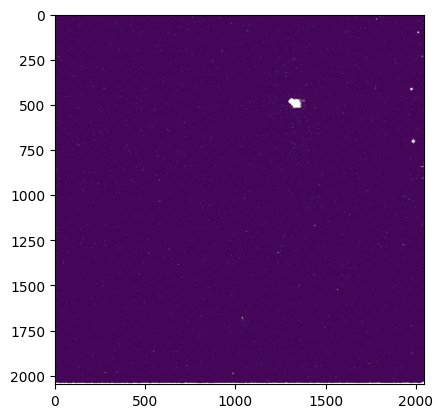

In [300]:
plt.imshow(ref_im_F090W)

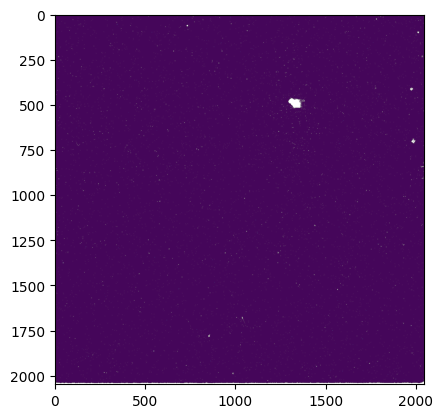

In [301]:
plt.imshow(int1_im_F090W)

In [302]:
res = int1_im_F090W - ref_im_F090W 

In [303]:
res = np.nan_to_num(res, nan=0.0)
res

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(2048, 2048), dtype=float32)

Make all the nan's 0

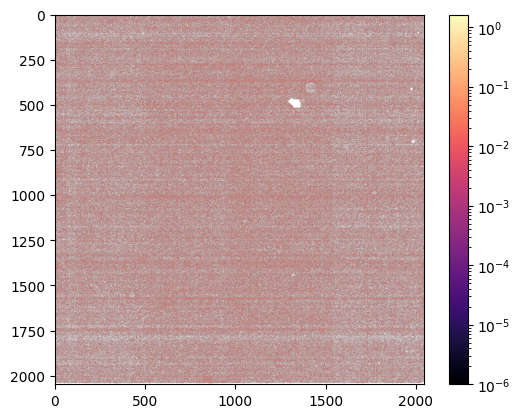

In [304]:
%matplotlib inline
plt.imshow(res, cmap='magma', norm=LogNorm(vmin=1e-6, vmax=np.nanmax(res)))
plt.colorbar()